In [3]:
!python3 --version
import tensorflow as tf
print("Tensorflow", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage
import skimage.draw
import cv2
import random
import math
import re
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import tifffile as tiff

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from custom_multi import nms_suppression_multi
from custom_multi import CustomConfig, CustomDataset

Python 3.9.18
Tensorflow 2.15.0
Num GPUs Available:  0
Device mapping: no known devices.


In [4]:
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  # To find local version of the library
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [6]:
class InferenceConfigMulti(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7 #Minimum probability value to accept a detected instance
    DETECTION_NMS_THRESHOLD = 0.3 # Non-maximum suppression threshold for detection

inference_config_multi = InferenceConfigMulti()

macro_model = modellib.MaskRCNN(mode="inference",
                            config=inference_config_multi,
                            model_dir=DEFAULT_LOGS_DIR)

LOG_PATH = '/Users/tom/Desktop/Stanford/RA/OligodendroSight/OL_mrcnn/logs'
MACRO_WEIGHTS_SUBPATH = 'multicell20240319T2245/mask_rcnn_multicell_0050.h5'
macro_model_path = os.path.join(LOG_PATH, MACRO_WEIGHTS_SUBPATH)

print("Loading macro weights from ", macro_model_path)
#model.load_weights(model_path, by_name=True) #deprecated on MacOS
tf.keras.Model.load_weights(macro_model.keras_model, macro_model_path , by_name=True, skip_mismatch=True)

RESULTS_NAME = 'test_cropper'
RESULTS_DIR = os.path.join(ROOT_DIR, "results", RESULTS_NAME)
os.makedirs(RESULTS_DIR, exist_ok=True)

Loading macro weights from  /Users/tom/Desktop/Stanford/RA/OligodendroSight/OL_mrcnn/logs/multicell20240319T2245/mask_rcnn_multicell_0050.h5


2024-04-15 13:54:15.645333: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_mask_bn2_1/moving_mean/Assign' id:17193 op device:{requested: '', assigned: ''} def:{{{node mrcnn_mask_bn2_1/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mrcnn_mask_bn2_1/moving_mean, mrcnn_mask_bn2_1/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [7]:
# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("/Users/tom/Desktop/Stanford/RA/OligodendroSight/OL_mrcnn/data", "valid")
dataset_val.prepare()

281.it12.20x.r1.3.tif


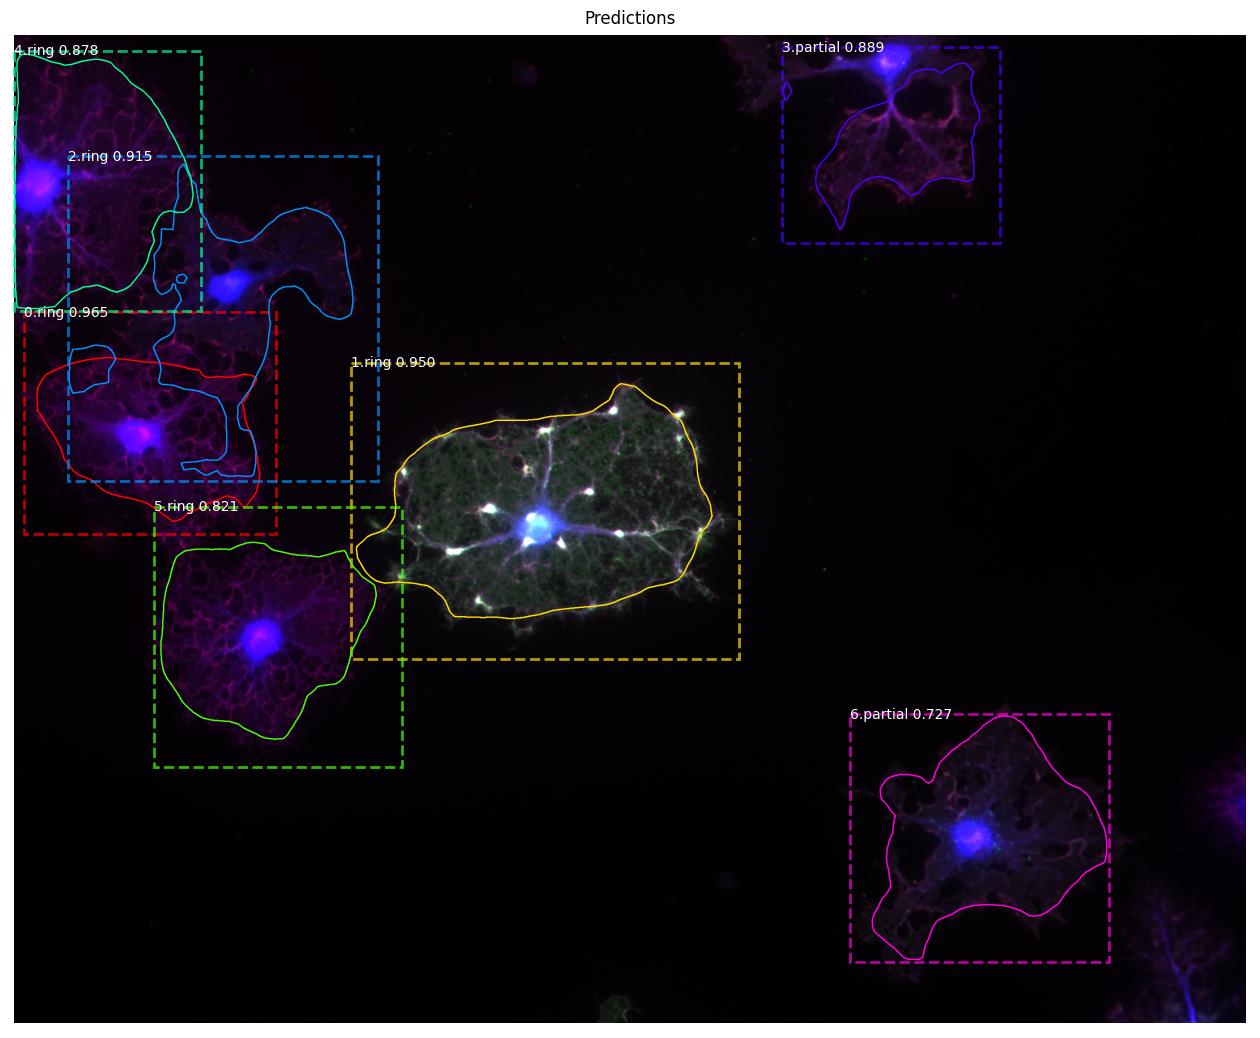

KeyboardInterrupt: Interrupted by user

In [9]:
real_test_dir = '/Users/tom/Desktop/Stanford/RA/OligodendroSight/OL_mrcnn/data/test/imgs'

image_paths = []
for filename in os.listdir(real_test_dir):
    if filename.endswith(".tif"):
        image_paths.append(os.path.join(real_test_dir, filename))

res_list = []
for image_path in image_paths:
    print(os.path.basename(image_path))
    image = skimage.io.imread(image_path)
    macro_results = macro_model.detect([image], verbose=0)
    macro_results = nms_suppression_multi(macro_results, 0.3)
    r = macro_results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], 
                                title="Predictions",
                                show_bbox=True, show_mask=False)
    img_res_dir = os.path.join(RESULTS_DIR, os.path.basename(image_path)[:-4])
    os.makedirs(img_res_dir, exist_ok=True)
    for i in range(r['masks'].shape[2]):
        class_name = dataset_val.class_names[r['class_ids'][i]]
        res_list.append([os.path.basename(image_path), i, dataset_val.class_names[r['class_ids'][i]], r['scores'][i], r['rois'][i]])
        cropped_img = image[r['rois'][i][0]:r['rois'][i][2], r['rois'][i][1]:r['rois'][i][3]]
        cv2.imwrite(os.path.join(img_res_dir, f'{i:04d}_' + class_name + '.tif'), cropped_img)
    input()

res_df = pd.DataFrame(res_list, columns=['image_name', 'detection_id', 'class', 'score', 'bbox'])
res_df.to_csv(os.path.join(RESULTS_DIR, 'results.csv'), index=False)